In [84]:
import pandas as pd
import psycopg2
from psycopg2 import sql
from psycopg2._psycopg import connection
from settings import DB_USER, DB_NAME, DB_PASSWORD, DB_HOST,DB_PORT, DB_SCHEMA 

def create_connection(db_name = DB_NAME,
                      db_host = DB_HOST,
                      db_user = DB_USER,
                      db_password = DB_PASSWORD,
                      db_port = DB_PORT) -> connection:
    
    return psycopg2.connect(database=db_name,
                            host=db_host,
                            user=db_user,
                            password=db_password,
                            port=db_port
                            )


def query_table(conn, 
                table_name = 'fx_aggregate_1m', 
                instrument= "USDSGD", 
                schema_name = DB_SCHEMA
                ):
    # create a new cursor
    with conn.cursor() as cur:
        # write the SQL query
        select_query = sql.SQL("SELECT * FROM {schema}.{table}").format(
            schema=sql.Identifier(schema_name),
            table=sql.Identifier(table_name)
        )
        # execute the SQL query
        cur.execute(select_query)
        # fetch all the rows
        rows = cur.fetchall()
        
    return rows
def load_ohlcvs():
    # create a connection
    conn = create_connection()
    # query the table
    rows = query_table(conn, table_name = 'fx_aggregate_1m', )
    # close the connection
    conn.close()

    # convert the data into pandas dataframe
    columns = ["Currency", "Datetime", "open", "high", "low", "close"]
    df = pd.DataFrame(rows[1:], columns=columns)
    df=df[columns[1:]]
    df.set_index('Datetime', inplace=True)
    # Convert decimal type open, high, low, close to float
    for col in ["open", "high","low","close"]:
        df[col] = df[col].astype(float)
    # Check for any zeros and replace them with nan
    df = df.replace(0, float("NaN"))
    # make column of zeros for volume
    df["volume"] = 0

    return df


df = load_ohlcvs()
df


,open,high,low,close,volume
Datetime,,,,,
2023-11-12 23:32:00+00:00,1.3599,1.3603,1.3599,1.3603,0
2023-11-12 23:33:00+00:00,1.3603,1.3603,1.3599,1.3601,0
2023-11-12 23:34:00+00:00,1.3603,1.3603,1.3599,1.3599,0
2023-11-12 23:35:00+00:00,1.3603,1.3603,1.3599,1.3603,0
2023-11-12 23:36:00+00:00,1.3603,1.3603,1.3599,1.3599,0
...,...,...,...,...,...
2023-11-16 08:53:00+00:00,1.3483,1.3487,1.3483,1.3487,0
2023-11-16 08:54:00+00:00,1.3487,1.3487,1.3484,1.3486,0
2023-11-16 08:55:00+00:00,1.3486,1.3486,1.3483,1.3484,0


In [85]:
df.index

DatetimeIndex(['2023-11-12 23:32:00+00:00', '2023-11-12 23:33:00+00:00',
               '2023-11-12 23:34:00+00:00', '2023-11-12 23:35:00+00:00',
               '2023-11-12 23:36:00+00:00', '2023-11-12 23:37:00+00:00',
               '2023-11-12 23:38:00+00:00', '2023-11-12 23:39:00+00:00',
               '2023-11-12 23:40:00+00:00', '2023-11-12 23:41:00+00:00',
               ...
               '2023-11-16 08:48:00+00:00', '2023-11-16 08:49:00+00:00',
               '2023-11-16 08:50:00+00:00', '2023-11-16 08:51:00+00:00',
               '2023-11-16 08:52:00+00:00', '2023-11-16 08:53:00+00:00',
               '2023-11-16 08:54:00+00:00', '2023-11-16 08:55:00+00:00',
               '2023-11-16 08:56:00+00:00', '2023-11-16 08:57:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=4628, freq=None)

In [26]:
def list_tables(conn, schema_name = DB_SCHEMA):
    with conn.cursor() as cur:
        cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = %s""", (schema_name,))
        print(DB_SCHEMA)
        for table in cur.fetchall():
            print(table)

# create a connection
conn = create_connection()

# list the tables
list_tables(conn)

# close the connection
conn.close()


signal_trading
('transactions',)
('execution_type',)
('side_type',)
('order_type',)
('fx_aggregate_1m',)
('fx_aggregate',)
('order_executions',)
('kgi_accounts',)
('metrics',)
('fx_aggregate_1d',)


In [77]:
from utils.pickle_helper import pickle_this
df0 = pickle_this(data=None, pickle_name="USDSGD_1m", path="./database/klines/metatrader/")
df0.columns

Index(['open', 'high', 'low', 'close', 'volume', 'close_time'], dtype='object')

In [78]:
import pandas as pd
import os
from datetime import datetime
import pytz
from utils.pickle_helper import pickle_this

def load_ohlcvs(instrument, 
                timeframe, 
                since, 
                to,
                limit, 
                update=False):
    
    # specify the folder
    csv_folder = "./database/klines/barchart/USDSGD_1m_raw"

    # get a list of all csv files in the folder
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    # initialize a list to store dataframes
    dfs = []

    # loop through the csv files and append to the dataframe list
    for file in csv_files:
        data = pd.read_csv(os.path.join(csv_folder, file))
        # remove the last row of each csv file
        data = data.iloc[:-1]
        dfs.append(data)

    # concatenate all dataframes in the list
    df = pd.concat(dfs, ignore_index=True)

    # convert 'Time' column to datetime
    df['datetime'] = pd.to_datetime(df['Time'])
    # convert time to UTC
    df['datetime'] = df['datetime'].dt.tz_localize("US/Central").dt.tz_convert('UTC')
    # set 'Time' column as index
    df.set_index('datetime', inplace=True)

    # create 'close_time' column as unix timestamp
    df['close_time'] = (df.index - pd.Timestamp("1970-01-01", tz='UTC')) // pd.Timedelta('1s')

    # sort the dataframe
    df.sort_index(inplace=True)
    # keep only ['open', 'high', 'low', 'close', 'volume', 'close_time'] columns
    # select only the desired columns
    df = df[['Open', 'High', 'Low', 'Last', 'Volume', 'close_time']]

    # rename the 'Last' column to 'close'
    df.rename(columns={'Last': 'close'}, inplace=True)
    df.columns = [col.lower() for col in df.columns]
    print(df)

                             open    high     low   close  volume  close_time
datetime                                                                     
2020-06-11 05:00:00+00:00  1.3887  1.3887  1.3884  1.3884   105.0  1591851600
2020-06-11 05:01:00+00:00  1.3885  1.3887  1.3884  1.3885   141.0  1591851660
2020-06-11 05:02:00+00:00  1.3885  1.3886  1.3884  1.3885    79.0  1591851720
2020-06-11 05:03:00+00:00  1.3885  1.3889  1.3885  1.3887    98.0  1591851780
2020-06-11 05:04:00+00:00  1.3888  1.3891  1.3887  1.3891    97.0  1591851840
...                           ...     ...     ...     ...     ...         ...
2023-11-10 01:39:00+00:00  1.3604  1.3605  1.3603  1.3604    99.0  1699580340
2023-11-10 01:40:00+00:00  1.3604  1.3605  1.3604  1.3604   113.0  1699580400
2023-11-10 01:41:00+00:00  1.3604  1.3605  1.3603  1.3605    84.0  1699580460
2023-11-10 01:42:00+00:00  1.3604  1.3605  1.3603  1.3604    94.0  1699580520
2023-11-10 01:43:00+00:00  1.3604  1.3605  1.3602  1.3603    86.

<Axes: xlabel='datetime'>

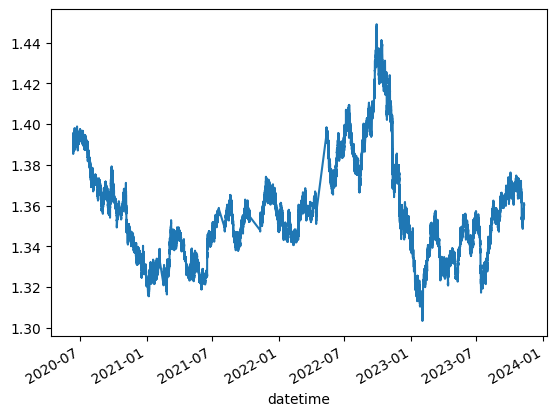